In [1]:
# Author: Anonymized
# License: CC-BY-NC-SA 4.0

# Import libraries

In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy as calculate_entropy
from kmodes.kprototypes import KPrototypes
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import osmnx as ox
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import gc
import ast
import re
import os
import glob

In [3]:
notebook_dir = os.path.abspath('')
PROJECT_ROOT = os.path.dirname(notebook_dir)

# Define all directories based on the Project Root
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures", "clustering")

os.makedirs(RESULTS_DIR, exist_ok=True) 
os.makedirs(FIGURES_DIR, exist_ok=True)

# Define the paths for the pre-combined input files
INPUT_CSV_PATH = os.path.join(RESULTS_DIR, "full_network.csv")

print(f"Project Root: {PROJECT_ROOT}")
print(f"Results will be saved to: {RESULTS_DIR}")
print(f"Figures will be saved to: {FIGURES_DIR}")
print("-" * 20)
print("Searching for the pre-combined network file...")

# --- Load the Single Pre-Combined File ---
if not os.path.exists(INPUT_CSV_PATH):
    raise FileNotFoundError(f"Could not find the pre-combined network file at: '{INPUT_CSV_PATH}'")

print(f"Found CSV file. Loading from: {INPUT_CSV_PATH}")
# Load the CSV file
df = pd.read_csv(INPUT_CSV_PATH, sep=";")
print("CSV loaded. Now converting to GeoDataFrame...")

# A CSV stores geometry as a text string (WKT). We must convert it back.
if 'geometry' in df.columns and not df['geometry'].empty:
    # The gpd.GeoSeries.from_wkt() function is designed for this conversion.
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    # Convert to GeoDataFrame and set CRS
    df = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:3857")
    print("Successfully converted to GeoDataFrame.")
else:
    print("Warning: 'geometry' column not found or is empty in the CSV. Cannot create GeoDataFrame.")

# --- Ensure unique_edge_id and city_id exist ---

# We assume 'city_id' exists as a column (it should, from the original data acquisition)
if 'city_id' not in df.columns:
    # Handle error case if city_id is missing, as it's required for unique_edge_id
    raise ValueError("Column 'city_id' is missing from the input CSV, cannot proceed.")

# Create a unique ID for every segment
df = df.reset_index(drop=True)
df['unique_edge_id'] = df['city_id'] + "_" + df.index.astype(str)
print("Created 'unique_edge_id' column.")

# --- Verify Loaded Data ---
print("\nFull dataset loaded successfully.")
print("Data type:", type(df))
print("Shape:", df.shape)
print("Memory usage (approx):", df.memory_usage(deep=True).sum() / (1024**2), "MB")

print("\nData head (note 'unique_edge_id' and 'city_id' columns):")
print(df[['unique_edge_id', 'city_id', 'highway', 'length', 'geometry']].head())

# --- FILTERING STEP (Optional, for debugging) ---
# This part can remain as is, in case you want to test the centroid-saving on a single city.
# city_to_keep = 'fortaleza'
# print(f"\nFiltering for rows where 'city_id' is '{city_to_keep}'...")
# df = df[df['city_id'] == city_to_keep].copy()
# print("Filtered dataset shape:", df.shape)

Project Root: /Anonymized
Results will be saved to: /Anonymized/results
Figures will be saved to: /Anonymized/results/figures/clustering
--------------------
Searching for the pre-combined network file...
Found CSV file. Loading from: /Anonymized/results/full_network.csv


/opt/homebrew/Caskroom/miniconda/base/envs/mapillary/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


CSV loaded. Now converting to GeoDataFrame...
Successfully converted to GeoDataFrame.
Created 'unique_edge_id' column.

Full dataset loaded successfully.
Data type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (7002507, 18)
Memory usage (approx): 3980.132387161255 MB

Data head (note 'unique_edge_id' and 'city_id' columns):
  unique_edge_id city_id            highway   length  \
0       zurich_0  zurich      motorway_link  193.902   
1       zurich_1  zurich  primary, motorway  830.220   
2       zurich_2  zurich           motorway  826.884   
3       zurich_3  zurich           tertiary   49.283   
4       zurich_4  zurich           tertiary   36.766   

                                            geometry  
0  LINESTRING (944275.440 6006892.573, 944327.248...  
1  LINESTRING (945734.438 6006514.616, 945714.712...  
2  LINESTRING (943477.613 6007383.560, 943493.743...  
3  LINESTRING (947179.409 6005223.103, 947175.925...  
4  LINESTRING (947199.870 6005133.431, 947169.368...  

In [4]:
# --- 0. Loading data ---
#dtypes_spec = {
#    'lanes': str,
#    'maxspeed': str
#}

#df = pd.read_csv("full_network.csv", sep=';', dtype=dtypes_spec)

#print("Full dataset loaded. Shape:", df.shape)
#print("Memory usage (approx):", df.memory_usage(deep=True).sum() / (1024**2), "MB")

# --- FILTERING STEP ---
#Uncomment this whole part to help debugging or only perform clustering with a single city

#city_prefix_to_keep = 'fortaleza_'
#print(f"\nFiltering for rows where 'unique_edge_id' starts with '{city_prefix_to_keep}'...")

# Ensure the column exists
#if 'unique_edge_id' not in df_full.columns:
#    raise ValueError("Column 'unique_edge_id' not found in the DataFrame!")

# Use boolean indexing with .str.startswith() for efficient filtering
# Use .copy() to create a new DataFrame and avoid potential SettingWithCopyWarning later
#df_filtered = df_full[df_full['unique_edge_id'].str.startswith(city_prefix_to_keep)].copy()

#print(f"Filtering complete.")
#print("Filtered dataset shape:", df_filtered.shape)

In [5]:
print("\n--- Column Summary and Value Counts ---")

# Define columns to skip for the detailed value_counts analysis.
# These columns have too many unique values to be useful for this type of summary.
EXCLUDE_FROM_VALUE_COUNTS = ['geometry']

for column in df.columns:
    print(f"\n--- Column: {column} ---")
    
    # --- Step 1: Print Basic Summary Stats for ALL columns ---
    dtype = df[column].dtype
    num_unique = df[column].nunique()
    num_missing = df[column].isnull().sum()
    
    print(f"  - Data Type: {dtype}")
    print(f"  - Unique Values: {num_unique}")
    print(f"  - Missing Values: {num_missing} ({num_missing / len(df) * 100:.2f}%)")

    # --- Step 2: Conditionally print value_counts ---
    if column in EXCLUDE_FROM_VALUE_COUNTS:
        print("  - Value counts skipped for this column (high cardinality).")
        continue # Move to the next column in the loop

    # If the column is not in the exclusion list, proceed with value counts
    print("  - Top 50 Value Counts (including missing values):")
    
    # Using dropna=False to see NaNs if they are frequent
    value_counts_series = df[column].value_counts(dropna=False).head(50)
    
    if value_counts_series.empty:
        print("    No values in this column.")
    else:
        # Using .to_string() gives clean, aligned output for the series
        with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
            print(value_counts_series.to_string())
            
print("\n" + "-" * 50)
print("Column summary complete.")


--- Column Summary and Value Counts ---

--- Column: highway ---
  - Data Type: object
  - Unique Values: 204
  - Missing Values: 0 (0.00%)
  - Top 50 Value Counts (including missing values):
residential                    4596738
tertiary                        786355
secondary                       474779
unclassified                    363037
primary                         307340
living_street                   191382
trunk                            83776
primary_link                     40471
motorway_link                    33930
secondary_link                   33383
trunk_link                       27769
tertiary_link                    22781
motorway                         20906
busway                            4866
residential, living_street        2970
residential, unclassified         2612
unclassified, residential         2254
living_street, residential         843
unclassified, tertiary             666
residential, tertiary              660
tertiary, residential      

In [6]:
print("\n--- Cleaning 'lanes' column ---")

def clean_lanes_value(val):
    if pd.isna(val):  # Handles np.nan, pd.NA, None
        return np.nan

    # Convert to string and strip whitespace, as 'lanes' was read with dtype=str
    s_val = str(val).strip()

    if not s_val:  # Handles empty strings
        return np.nan

    # Method 1: Direct conversion to integer (e.g., "2", "3")
    try:
        return int(s_val)
    except ValueError:
        pass  # Not a simple integer string, try next method

    # Method 2: Conversion to float, then floor (e.g., "1.5" -> 1, "2.0" -> 2)
    try:
        float_val = float(s_val)
        return int(np.floor(float_val))
    except ValueError:
        pass  # Not a float string, try next method

    # Method 3: Parse list-like strings (e.g., "['2', '3']", "['4','2','3']")
    if s_val.startswith('[') and s_val.endswith(']'):
        try:
            # ast.literal_eval safely parses string representations of Python literals
            parsed_list = ast.literal_eval(s_val)

            if not isinstance(parsed_list, list): # Ensure it was a list
                return np.nan

            numbers_in_list = []
            for item in parsed_list:
                try:
                    # Convert item to float (handles int, float, or string numbers like '2', '1.5')
                    # Then floor and convert to int
                    num = float(item)
                    numbers_in_list.append(int(np.floor(num)))
                except (ValueError, TypeError):
                    # If an item in the list is not a number (e.g., 'yes', None within list)
                    # Mark the entire original list-string as problematic
                    return np.nan
            
            if numbers_in_list: # If we successfully extracted numbers
                return min(numbers_in_list)
            else:
                # List was empty or all items were non-numeric after parsing
                return np.nan
        except (ValueError, SyntaxError, TypeError):
            # ast.literal_eval failed (e.g., malformed list string like "[1, bad, 2]")
            # or an unexpected type was encountered during item processing
            return np.nan
            
    # If none of the above patterns matched, it's a "weird value"
    return np.nan

# Apply the cleaning function to the 'lanes' column
df['lanes_cleaned'] = df['lanes'].apply(clean_lanes_value)

print("\nValue counts for 'lanes_cleaned' (Top 50):")
print(df['lanes_cleaned'].value_counts(dropna=False).head(50))
print(f"\nData type of 'lanes_cleaned': {df['lanes_cleaned'].dtype}")

# Sanity check: Count how many original NaNs are still NaNs
original_nans = df['lanes'].isna().sum()
cleaned_nans = df['lanes_cleaned'].isna().sum()
print(f"Original NaNs in 'lanes': {original_nans}")
print(f"NaNs in 'lanes_cleaned' (includes original NaNs and newly created NaNs from unparseable values): {cleaned_nans}")

print("-" * 50)


--- Cleaning 'lanes' column ---

Value counts for 'lanes_cleaned' (Top 50):
NaN     5376645
2.0      994296
1.0      345326
3.0      169266
4.0       94451
5.0       14640
6.0        6481
7.0        1040
8.0         144
0.0          63
10.0         42
30.0         32
9.0          30
12.0         14
11.0          9
40.0          8
21.0          6
20.0          4
14.0          3
35.0          3
16.0          2
50.0          1
45.0          1
Name: lanes_cleaned, dtype: int64

Data type of 'lanes_cleaned': float64
Original NaNs in 'lanes': 5376602
NaNs in 'lanes_cleaned' (includes original NaNs and newly created NaNs from unparseable values): 5376645
--------------------------------------------------


In [7]:
print("\n--- Cleaning 'highway' column ---")

# Define the hierarchy: Lower index = higher priority
highway_hierarchy_list = [
    'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'busway',
    'unclassified', 'residential', 'living_street', 'service', 'road',
    'cycleway', 'footway', 'pedestrian', 'path', 'steps', 'track', 'emergency_bay'
]
# Create a mapping from highway type to its priority (index)
highway_priority_map = {road_type: i for i, road_type in enumerate(highway_hierarchy_list)}

def clean_highway_value(val, priority_map):
    if pd.isna(val):
        return np.nan # Will be filled later

    # Convert to string, lowercase, and strip whitespace
    s_val = str(val).lower().strip()

    if not s_val: # Handle empty strings after stripping
        return np.nan

    # Split by comma, then strip whitespace from each part
    parts = [p.strip() for p in s_val.split(',')]

    processed_parts = []
    for part in parts:
        if not part: # Skip empty strings resulting from "a, ,b"
            continue
        # Handle _link: e.g., "secondary_link" -> "secondary"
        if part.endswith("_link"):
            part = part[:-5] # Remove "_link"
        processed_parts.append(part)

    if not processed_parts: # If all parts were empty or just delimiters
        return np.nan

    # Find the highest priority part based on the hierarchy
    # Assign a very high number (low priority) to types not in the hierarchy map
    best_part_found = None
    current_highest_priority = float('inf') # Lower value means higher priority

    for part in processed_parts:
        priority = priority_map.get(part, float('inf')) # Get priority, default to very low if not in map
        if priority < current_highest_priority:
            current_highest_priority = priority
            best_part_found = part
        # If two parts have the same priority (e.g. "primary, primary_link" -> both become "primary"),
        # the first one encountered is kept.

    # If no part was found in the hierarchy map (e.g. "random_tag, another_random"),
    # it will return the first part from processed_parts.
    # If only one part was present and it's not in hierarchy, it's returned.
    if best_part_found is None and processed_parts: # Should only happen if all parts are not in map
        return processed_parts[0] # Default to the first processed part if none are in hierarchy
        
    return best_part_found


# Apply the cleaning function
df['highway_cleaned'] = df['highway'].apply(lambda x: clean_highway_value(x, highway_priority_map))

print("\nValue counts for 'highway_cleaned' (Top 50) before NaN imputation:")
print(df['highway_cleaned'].value_counts(dropna=False).head(50))

# K-Prototypes expects categorical features to be strings, and NaNs can cause issues.
# Impute NaNs with a specific string category like 'unknown_highway'.
df['highway_cleaned'].fillna('unknown_highway', inplace=True)

print("\nValue counts for 'highway_cleaned' (Top 50) after NaN imputation:")
print(df['highway_cleaned'].value_counts(dropna=False).head(50))
print(f"\nData type of 'highway_cleaned': {df['highway_cleaned'].dtype}")
print(f"Number of unique categories in 'highway_cleaned': {df['highway_cleaned'].nunique()}")
print("-" * 50)


--- Cleaning 'highway' column ---

Value counts for 'highway_cleaned' (Top 50) before NaN imputation:
residential      4600644
tertiary          811677
secondary         509011
unclassified      368078
primary           348436
living_street     191383
trunk             112088
motorway           55772
busway              4883
road                 353
emergency_bay         48
bus_stop              22
closed                21
escape                19
rest_area             18
scramble              17
disused               14
crossing              10
yes                    4
ladder                 3
no                     3
passing_place          2
dummy                  1
Name: highway_cleaned, dtype: int64

Value counts for 'highway_cleaned' (Top 50) after NaN imputation:
residential      4600644
tertiary          811677
secondary         509011
unclassified      368078
primary           348436
living_street     191383
trunk             112088
motorway           55772
busway             

In [8]:
print("\n--- Cleaning 'maxspeed' column ---")

# Conversion factor
MPH_TO_KPH = 1.60934

# Textual speed conversion map (KPH values)
# These will be converted to string later if they are to be categorical.
text_speed_map_kph = {
    'ru:urban': 60,
    'ro:urban': 50,
    'rs:urban': 50,
}

def parse_single_speed_value(speed_token_str):
    """
    Parses a single speed token (e.g., "25 mph", "RU:urban", "50")
    into a numeric KPH value. Returns None if unparseable.
    """
    token = speed_token_str.lower().strip()

    if not token:
        return None

    # 1. Check textual map
    if token in text_speed_map_kph:
        return float(text_speed_map_kph[token])

    # 2. Check for MPH
    if 'mph' in token:
        # Extract numbers (can handle "20 mph" or "20mph")
        numbers = re.findall(r"[-+]?\d*\.\d+|\d+", token)
        if numbers:
            try:
                mph_val = float(numbers[0])
                kph_val = mph_val * MPH_TO_KPH
                # Round to nearest 5 KPH
                return round(kph_val / 5.0) * 5.0
            except ValueError:
                return None # Should not happen if re.findall works
        else: # 'mph' present but no number found
            return None

    # 3. Try direct numeric conversion (assume KPH)
    try:
        # This handles integers "50" and floats "45.5"
        return float(token)
    except ValueError:
        return None # Not a direct number, not mph, not in text map


def clean_maxspeed_value(val):
    if pd.isna(val):
        return np.nan # Keep NaNs

    s_val = str(val).strip()
    if not s_val:
        return np.nan

    # Split by common delimiters like comma or semicolon
    # Allows for "30, 50" or "20 mph; 30"
    parts = re.split(r'[,;]', s_val)

    kph_values_found = []
    for part_str in parts:
        if not part_str.strip(): # Skip empty parts from "val1,,val2"
            continue
        numeric_kph = parse_single_speed_value(part_str)
        if numeric_kph is not None:
            kph_values_found.append(numeric_kph)

    if not kph_values_found: # No valid KPH value could be parsed from any part
        return np.nan

    # Choose the lowest KPH value
    final_kph_value = min(kph_values_found)

    # Convert to integer if it's a whole number (e.g., 50.0 -> 50), then to string
    # This ensures "50.0" becomes "50" for categorical use.
    if final_kph_value == int(final_kph_value):
        return str(int(final_kph_value))
    else:
        # For speeds like 42.5 (if rounding to nearest 2.5 was used, or came from data)
        # Keep one decimal place or as is for the string representation.
        # For rounding to nearest 5, this case (non-integer) should be rare unless original data had it.
        return str(final_kph_value)


# Apply the cleaning function
df['maxspeed_cleaned'] = df['maxspeed'].apply(clean_maxspeed_value)

print("\nValue counts for 'maxspeed_cleaned' (Top 50) before any further NaN handling:")
print(df['maxspeed_cleaned'].value_counts(dropna=False).head(50))

print(f"\nData type of 'maxspeed_cleaned': {df['maxspeed_cleaned'].dtype}")
print(f"Number of unique categories in 'maxspeed_cleaned' (excl NaN): {df['maxspeed_cleaned'].nunique()}")
print("-" * 50)


--- Cleaning 'maxspeed' column ---

Value counts for 'maxspeed_cleaned' (Top 50) before any further NaN handling:
NaN    5289238
50      516294
30      471963
40      316888
60      219091
20       41022
80       35802
70       27302
45       25260
55       15986
100       8395
90        6386
65        6327
15        3857
10        3715
36        3368
25        2871
120       1752
105        985
95         853
5          766
18         744
110        731
35         726
130        368
28         312
75         301
12         280
16         148
115        109
48         102
0           93
140         93
2           62
8           52
14          33
84          25
6           21
56          20
32          20
7           20
4           19
26          19
22          17
13          13
17          13
3           11
42          10
1            4
34           4
Name: maxspeed_cleaned, dtype: int64

Data type of 'maxspeed_cleaned': object
Number of unique categories in 'maxspeed_cleaned' (excl N


--- Handling Numerical Features: Imputation and Outlier Treatment ---
Numerical columns to process: ['lanes_cleaned', 'traffic_sign_count', 'highway_traffic_signals_count', 'crossing_traffic_signals_count', 'crossing_unmarked_count', 'crossing_uncontrolled_count', 'highway_stop_count', 'highway_give_way_count']

--- Imputing NaNs in Numerical Columns ---
Imputing NaNs in 'lanes_cleaned' with median: 2.0 (Original NaNs: 5376645)
No NaNs found in 'traffic_sign_count'.
No NaNs found in 'highway_traffic_signals_count'.
No NaNs found in 'crossing_traffic_signals_count'.
No NaNs found in 'crossing_unmarked_count'.
No NaNs found in 'crossing_uncontrolled_count'.
No NaNs found in 'highway_stop_count'.
No NaNs found in 'highway_give_way_count'.
------------------------------

--- Visualizing Numerical Distributions (before outlier treatment) ---

--- lanes_cleaned ---
count    7.002507e+06
mean     2.013000e+00
std      4.161565e-01
min      0.000000e+00
25%      2.000000e+00
50%      2.000000

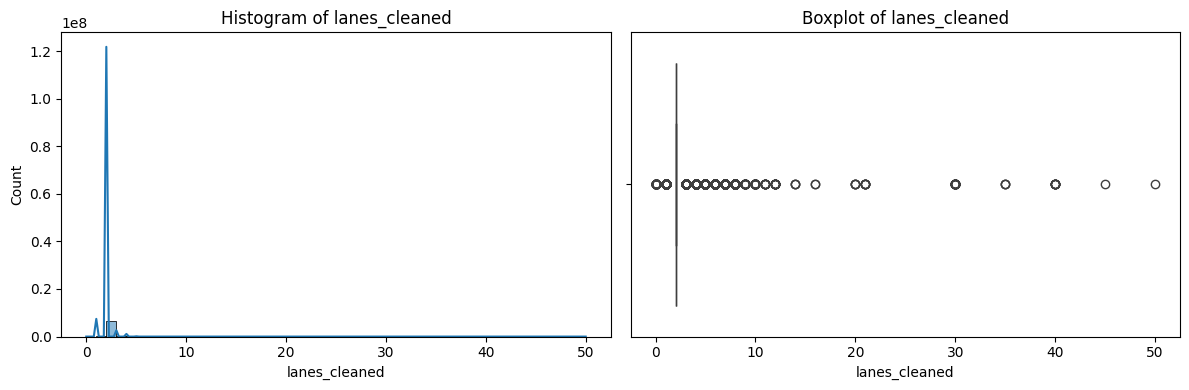


--- traffic_sign_count ---
count    7.002507e+06
mean     4.812235e-01
std      5.247796e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.473000e+03
Name: traffic_sign_count, dtype: float64


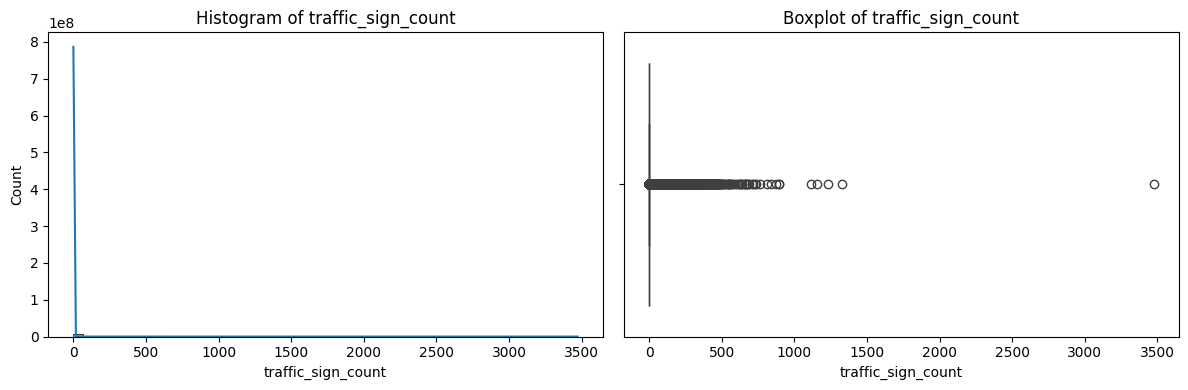


--- highway_traffic_signals_count ---
count    7.002507e+06
mean     7.993094e-02
std      3.421952e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: highway_traffic_signals_count, dtype: float64


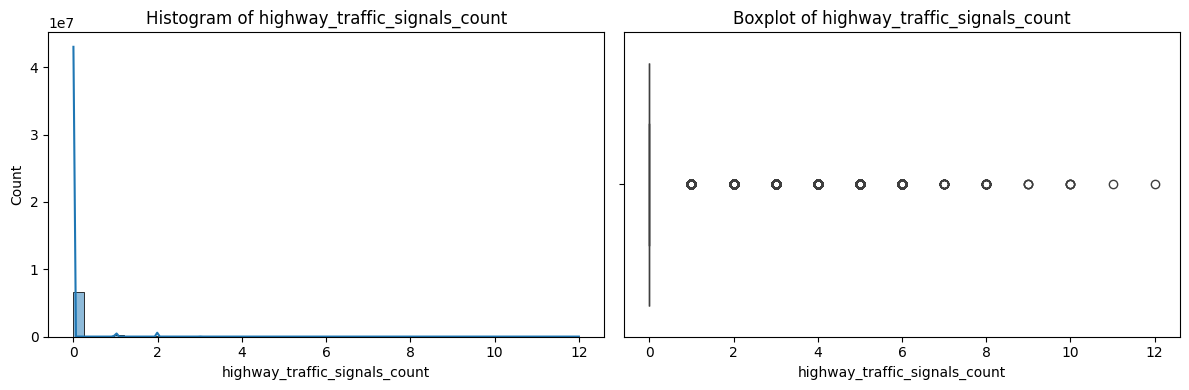


--- crossing_traffic_signals_count ---
count    7.002507e+06
mean     4.308371e-02
std      2.472808e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.100000e+01
Name: crossing_traffic_signals_count, dtype: float64


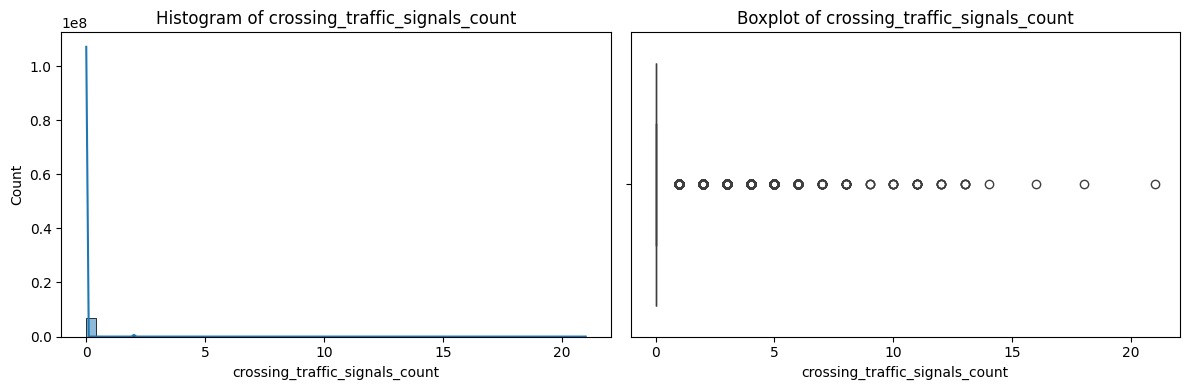


--- crossing_unmarked_count ---
count    7.002507e+06
mean     4.115869e-02
std      2.471750e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.600000e+01
Name: crossing_unmarked_count, dtype: float64


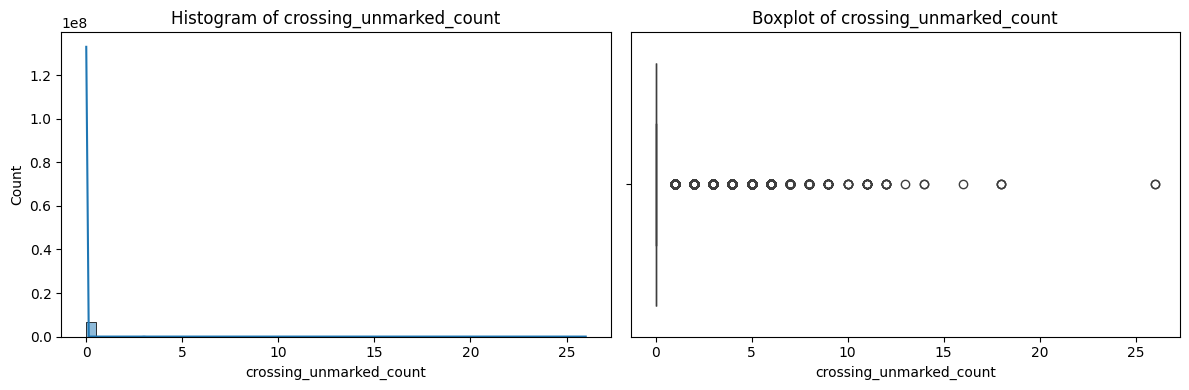


--- crossing_uncontrolled_count ---
count    7.002507e+06
mean     3.874769e-02
std      2.392184e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.100000e+01
Name: crossing_uncontrolled_count, dtype: float64


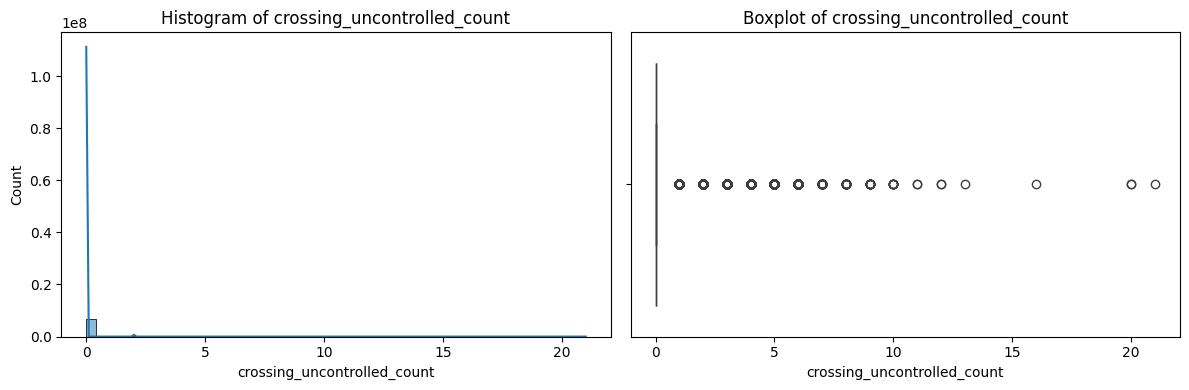


--- highway_stop_count ---
count    7.002507e+06
mean     2.515556e-02
std      1.843969e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: highway_stop_count, dtype: float64


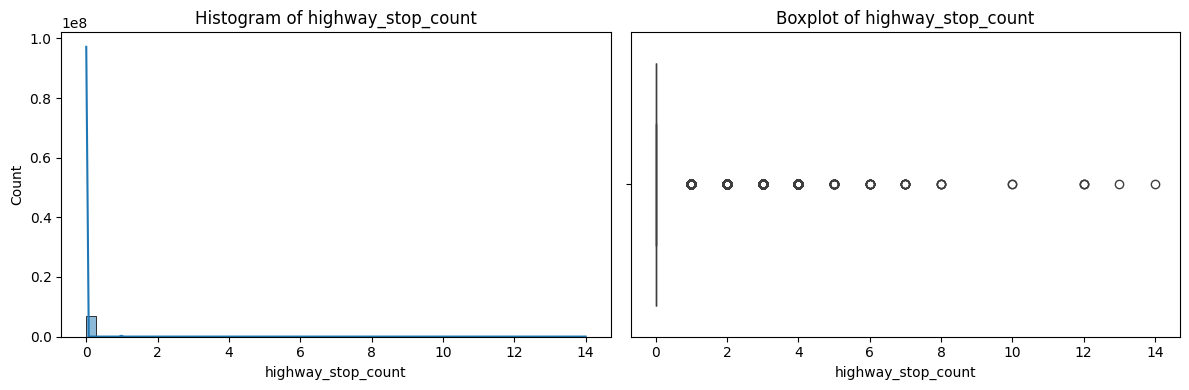


--- highway_give_way_count ---
count    7.002507e+06
mean     9.740369e-03
std      1.046649e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: highway_give_way_count, dtype: float64


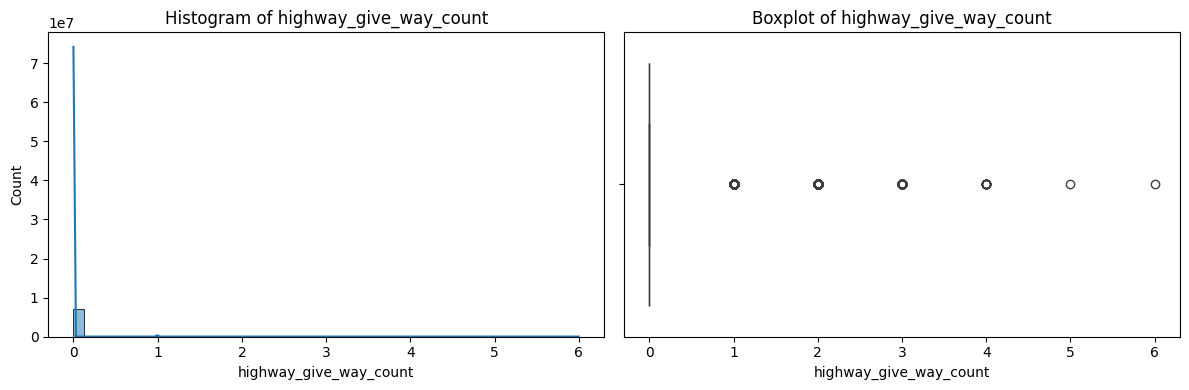

------------------------------

--- Applying Outlier Treatment (Capping) ---
Capped 'lanes_cleaned' at 99.5th percentile (4.00). Original max: 50.00. Values at new max: 116911.
Capped 'traffic_sign_count' at 99.5th percentile (15.00). Original max: 3473.00. Values at new max: 37384.
Capped 'highway_traffic_signals_count' at 99.5th percentile (2.00). Original max: 12.00. Values at new max: 119464.
Capped 'crossing_traffic_signals_count' at 99.5th percentile (2.00). Original max: 21.00. Values at new max: 50036.
Capped 'crossing_unmarked_count' at 99.5th percentile (2.00). Original max: 26.00. Values at new max: 52685.
Capped 'crossing_uncontrolled_count' at 99.5th percentile (2.00). Original max: 21.00. Values at new max: 51036.
Capped 'highway_stop_count' at 99.5th percentile (1.00). Original max: 14.00. Values at new max: 145371.
Capped 'highway_give_way_count' at 99.5th percentile (1.00). Original max: 6.00. Values at new max: 63767.
------------------------------

--- Visualizing Nu

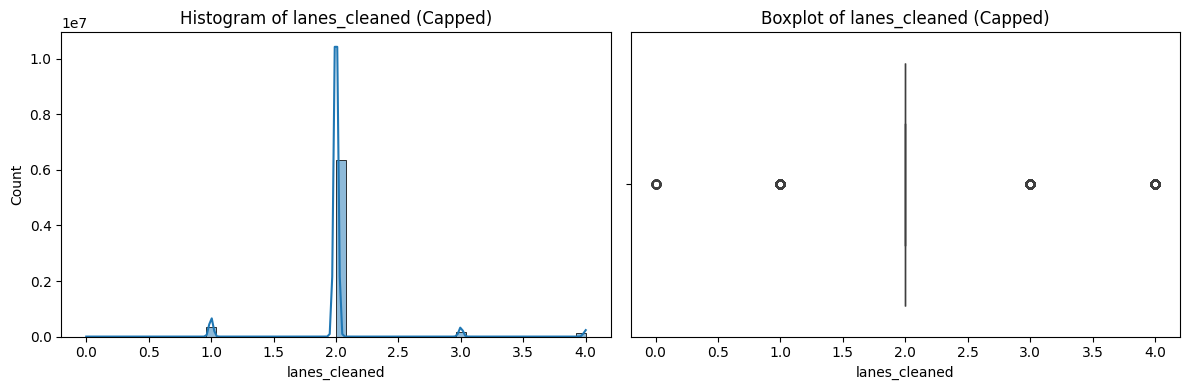


--- traffic_sign_count (After Capping) ---
count    7.002507e+06
mean     3.272011e-01
std      1.557045e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.500000e+01
Name: traffic_sign_count, dtype: float64


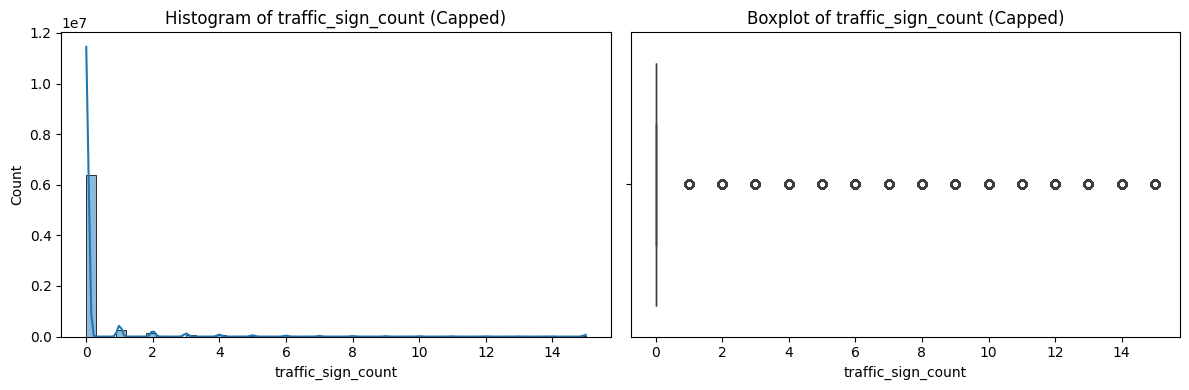


--- highway_traffic_signals_count (After Capping) ---
count    7.002507e+06
mean     7.797764e-02
std      3.256033e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: highway_traffic_signals_count, dtype: float64


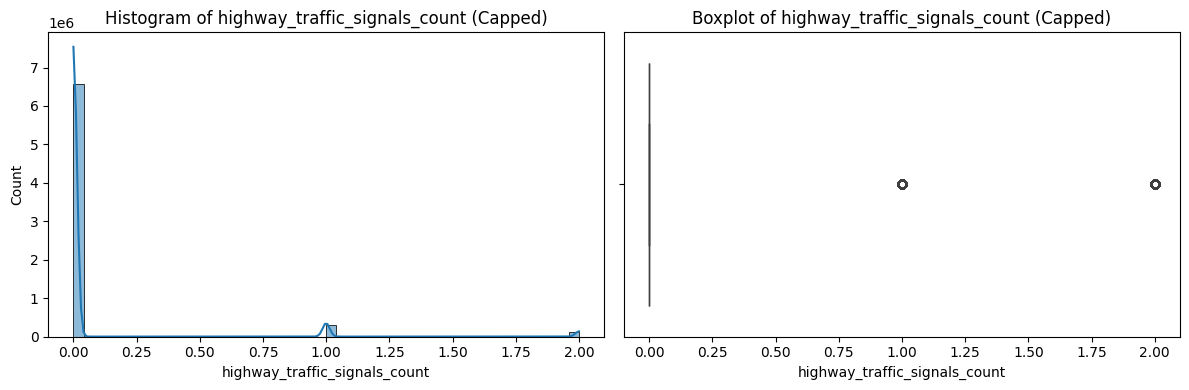


--- crossing_traffic_signals_count (After Capping) ---
count    7.002507e+06
mean     4.197040e-02
std      2.334519e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: crossing_traffic_signals_count, dtype: float64


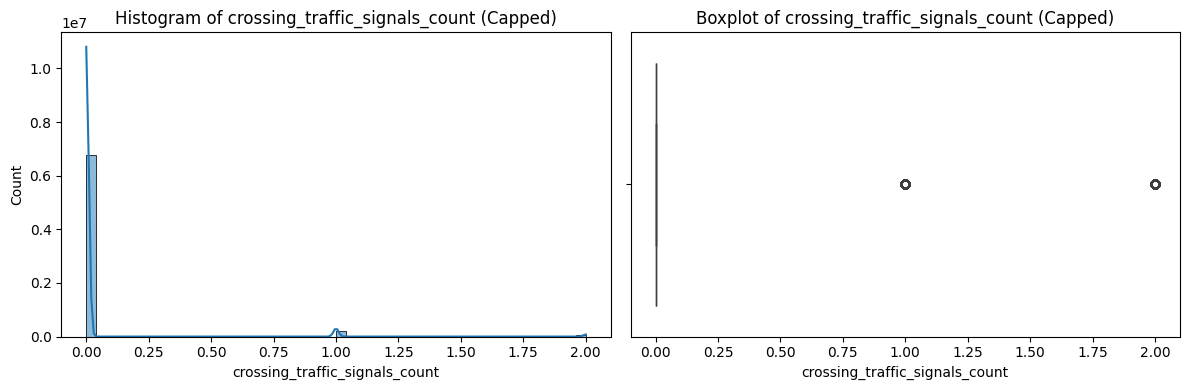


--- crossing_unmarked_count (After Capping) ---
count    7.002507e+06
mean     3.997868e-02
std      2.311447e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: crossing_unmarked_count, dtype: float64


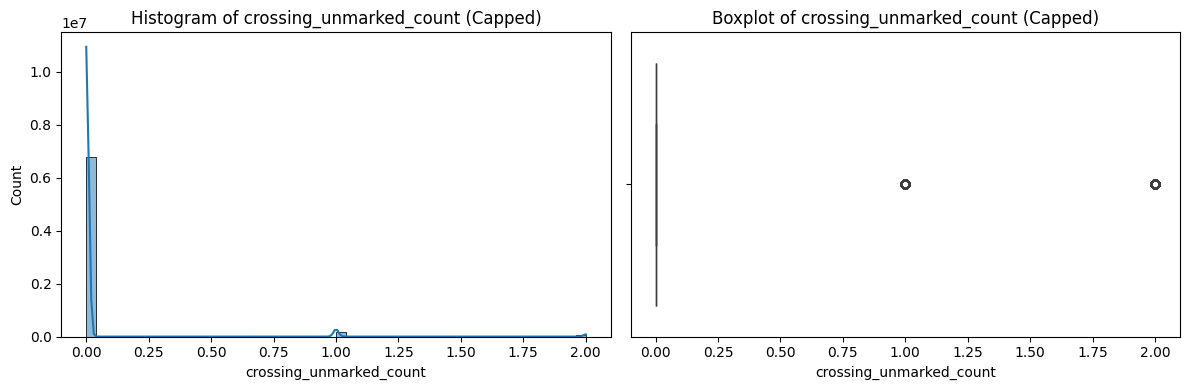


--- crossing_uncontrolled_count (After Capping) ---
count    7.002507e+06
mean     3.773006e-02
std      2.255726e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: crossing_uncontrolled_count, dtype: float64


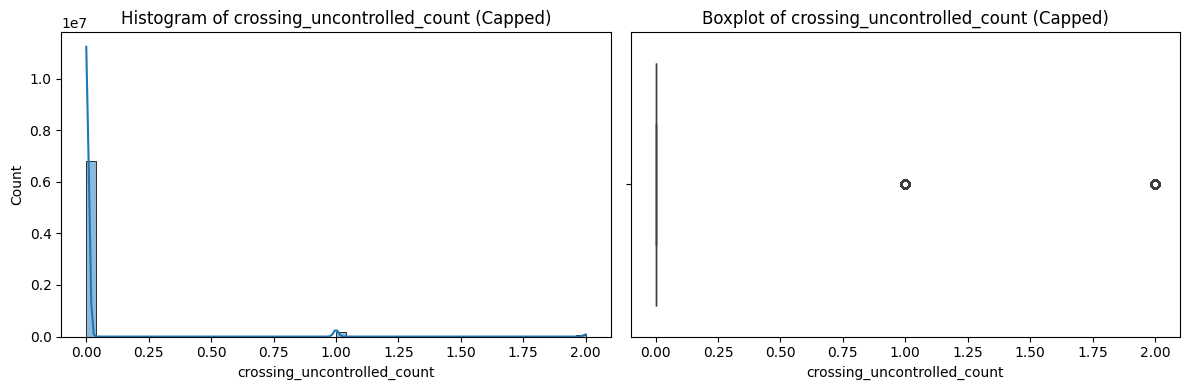


--- highway_stop_count (After Capping) ---
count    7.002507e+06
mean     2.075985e-02
std      1.425794e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: highway_stop_count, dtype: float64


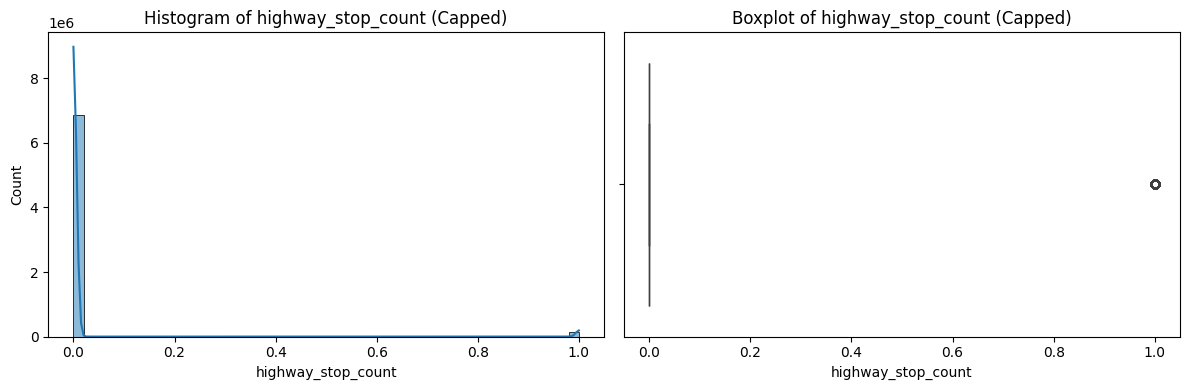


--- highway_give_way_count (After Capping) ---
count    7.002507e+06
mean     9.106310e-03
std      9.499151e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: highway_give_way_count, dtype: float64


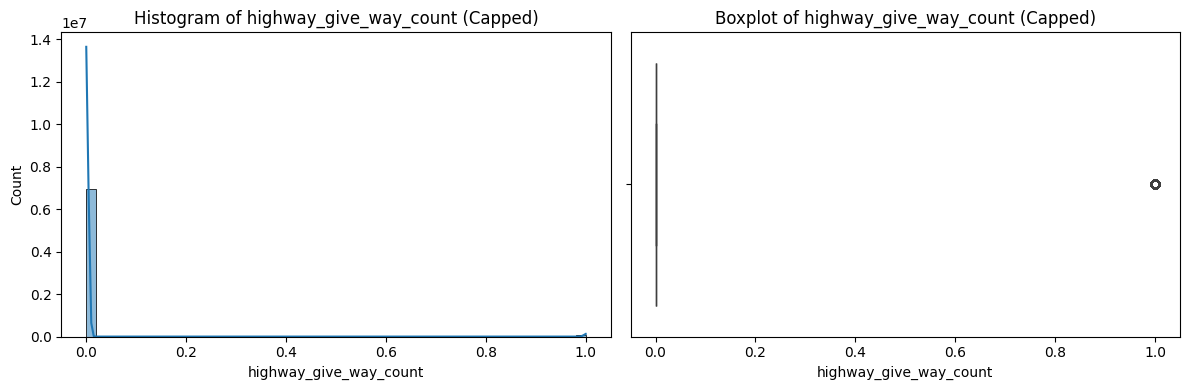

--------------------------------------------------


In [9]:
print("\n--- Handling Numerical Features: Imputation and Outlier Treatment ---")

# --- 1. Define Numerical Columns to Process ---
# These are the raw numerical columns and the newly cleaned 'lanes_cleaned'
# We process source columns for TotalCrossingCount *before* summing.
numerical_cols_to_process = [
    'lanes_cleaned',                 # Already created and is float (can have NaN)
    'traffic_sign_count',            # Original numerical
    'highway_traffic_signals_count', # Original numerical
    'crossing_traffic_signals_count',# Original numerical (source for TotalCrossingCount)
    'crossing_unmarked_count',       # Original numerical (source for TotalCrossingCount)
    'crossing_uncontrolled_count',   # Original numerical (source for TotalCrossingCount)
    'highway_stop_count',            # Original numerical
    'highway_give_way_count'         # Original numerical
]

# Ensure these columns exist in the DataFrame
numerical_cols_to_process = [col for col in numerical_cols_to_process if col in df.columns]
if not numerical_cols_to_process:
    print("No numerical columns found to process. Skipping this section.")
else:
    print(f"Numerical columns to process: {numerical_cols_to_process}")

    # --- 2. Impute NaNs in Numerical Columns ---
    print("\n--- Imputing NaNs in Numerical Columns ---")
    for col in numerical_cols_to_process:
        if df[col].isnull().any():
            original_nan_count = df[col].isnull().sum()
            if col == 'lanes_cleaned':
                # For 'lanes_cleaned', median imputation is often a good choice.
                # Or a specific default like 1 or 2 if that makes more sense.
                impute_value = df[col].median()
                # Ensure impute_value is not NaN itself if the column is all NaNs
                if pd.isna(impute_value):
                    impute_value = 1 # Fallback if median is NaN
                print(f"Imputing NaNs in '{col}' with median: {impute_value} (Original NaNs: {original_nan_count})")
            else: # For count columns, 0 is a common and sensible imputation
                impute_value = 0
                print(f"Imputing NaNs in '{col}' with 0 (Original NaNs: {original_nan_count})")
            df[col].fillna(impute_value, inplace=True)
        else:
            print(f"No NaNs found in '{col}'.")
    print("-" * 30)

    # --- 3. Visualize Distributions and Identify Outliers ---
    print("\n--- Visualizing Numerical Distributions (before outlier treatment) ---")
    for col in numerical_cols_to_process:
        if col not in df.columns:
            print(f"Column {col} not found for visualization, skipping.")
            continue
        
        print(f"\n--- {col} ---")
        print(df[col].describe())

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()
    print("-" * 30)

    # --- 4. Apply Outlier Treatment (Capping/Winsorization) ---
    print("\n--- Applying Outlier Treatment (Capping) ---")
    # Define capping percentiles.
    capping_percentiles = {
        'lanes_cleaned': 0.995,
        'traffic_sign_count': 0.995,
        'highway_traffic_signals_count': 0.995,
        'crossing_traffic_signals_count': 0.995,
        'crossing_unmarked_count': 0.995,
        'crossing_uncontrolled_count': 0.995,
        'highway_stop_count': 0.995,
        'highway_give_way_count': 0.995
    }

    for col in numerical_cols_to_process:
        if col not in df.columns:
            print(f"Column {col} not found for capping, skipping.")
            continue

        # Upper Capping
        percentile_val = capping_percentiles.get(col, 0.995)
        upper_limit = df[col].quantile(percentile_val)

        # Ensure upper_limit is not NaN (can happen if column is all NaNs or has very few distinct values)
        if pd.isna(upper_limit):
            print(f"Could not determine upper limit for '{col}' (quantile is NaN). Skipping capping for this column.")
            continue
            
        original_max = df[col].max()
        
        # Apply capping: values > upper_limit become upper_limit
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

        df[col] = df[col].round().astype(int) # Round to the nearest whole number and convert back to integer
        
        capped_count = (df[col] == upper_limit).sum() # Count how many were set to the upper limit
        
        print(f"Capped '{col}' at {percentile_val*100:.1f}th percentile ({upper_limit:.2f}). "
              f"Original max: {original_max:.2f}. Values at new max: {capped_count}.")

    print("-" * 30)

    # --- 5. Visualize Distributions (after outlier treatment) ---
    print("\n--- Visualizing Numerical Distributions (after outlier treatment) ---")
    for col in numerical_cols_to_process:
        if col not in df.columns:
            continue # Already printed message if not found
            
        print(f"\n--- {col} (After Capping) ---")
        print(df[col].describe())

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=50)
        plt.title(f'Histogram of {col} (Capped)')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} (Capped)')

        plt.tight_layout()
        plt.show()
    print("-" * 50)

In [10]:
print("\n--- Finalizing Cleaned Columns and Reverting to Original Names ---")

# --- 1. Handle columns that had a '_cleaned' version ---

# For 'lanes'
if 'lanes_cleaned' in df.columns:
    if 'lanes' in df.columns: # If original 'lanes' column still exists
        df.drop(columns=['lanes'], inplace=True) # Drop original raw 'lanes'
    df.rename(columns={'lanes_cleaned': 'lanes'}, inplace=True) # Rename 'lanes_cleaned' to 'lanes'
    print("Finalized 'lanes' column from 'lanes_cleaned'.")
else:
    print("Warning: 'lanes_cleaned' not found. 'lanes' column might not be fully processed as intended.")

# For 'highway'
if 'highway_cleaned' in df.columns:
    if 'highway' in df.columns:
        df.drop(columns=['highway'], inplace=True)
    df.rename(columns={'highway_cleaned': 'highway'}, inplace=True)
    print("Finalized 'highway' column from 'highway_cleaned'.")
else:
    print("Warning: 'highway_cleaned' not found. 'highway' column might not be fully processed as intended.")

# For 'maxspeed'
if 'maxspeed_cleaned' in df.columns:
    if 'maxspeed' in df.columns:
        df.drop(columns=['maxspeed'], inplace=True)
    df.rename(columns={'maxspeed_cleaned': 'maxspeed'}, inplace=True)
    print("Finalized 'maxspeed' column from 'maxspeed_cleaned'.")
else:
    print("Warning: 'maxspeed_cleaned' not found. 'maxspeed' column might not be fully processed as intended.")

# --- 2. Verify other directly cleaned columns (if they were not renamed but cleaned in place) ---
# These columns are assumed to have been cleaned in place (NaNs, outliers for numericals; NaNs, standardization for categoricals)
# No renaming needed for these if cleaned in place. Just a good place for a final check/print.

numerical_features_processed_inplace = [
    'traffic_sign_count',
    'highway_traffic_signals_count',
    'crossing_traffic_signals_count',
    'crossing_unmarked_count',
    'crossing_uncontrolled_count',
    'highway_stop_count',
    'highway_give_way_count'
]
print("\nVerifying numerical features processed in place:")
for col in numerical_features_processed_inplace:
    if col in df.columns:
        print(f"  '{col}': NaNs = {df[col].isnull().sum()}, dtype = {df[col].dtype}")
    else:
        print(f"  Warning: Expected numerical column '{col}' not found.")

categorical_features_processed_inplace = [
    'cycle_lane',
    'shared_cycle',
    'bus_lane'
]
print("\nVerifying categorical features processed in place (for HasSpecialLane):")
for col in categorical_features_processed_inplace:
    if col in df.columns:
        print(f"  '{col}': NaNs = {df[col].isnull().sum()}, dtype = {df[col].dtype}, "
              f"Unique values (sample): {df[col].unique()[:5]}") # Show some unique values
    else:
        print(f"  Warning: Expected categorical column '{col}' not found.")

print("-" * 50)


--- Finalizing Cleaned Columns and Reverting to Original Names ---
Finalized 'lanes' column from 'lanes_cleaned'.
Finalized 'highway' column from 'highway_cleaned'.
Finalized 'maxspeed' column from 'maxspeed_cleaned'.

Verifying numerical features processed in place:
  'traffic_sign_count': NaNs = 0, dtype = int64
  'highway_traffic_signals_count': NaNs = 0, dtype = int64
  'crossing_traffic_signals_count': NaNs = 0, dtype = int64
  'crossing_unmarked_count': NaNs = 0, dtype = int64
  'crossing_uncontrolled_count': NaNs = 0, dtype = int64
  'highway_stop_count': NaNs = 0, dtype = int64
  'highway_give_way_count': NaNs = 0, dtype = int64

Verifying categorical features processed in place (for HasSpecialLane):
  'cycle_lane': NaNs = 0, dtype = object, Unique values (sample): ['no' 'yes']
  'shared_cycle': NaNs = 0, dtype = object, Unique values (sample): ['no' 'yes']
  'bus_lane': NaNs = 0, dtype = object, Unique values (sample): ['no' 'yes']
--------------------------------------------

In [11]:
# 1. Create 'HasSpecialLane' (Binary Categorical)
# Define what values indicate presence of a special lane
cycle_lane_presence = ['yes']
shared_cycle_presence = ['yes']
bus_lane_presence = ['yes']

df['HasSpecialLane'] = (
    df['cycle_lane'].isin(cycle_lane_presence) |
    df['shared_cycle'].isin(shared_cycle_presence) |
    df['bus_lane'].isin(bus_lane_presence)
).astype(int) # Convert True/False to 1/0

print("Created 'HasSpecialLane'. Sample values:")
print(df[['cycle_lane', 'shared_cycle', 'bus_lane', 'HasSpecialLane']].head())

Created 'HasSpecialLane'. Sample values:
  cycle_lane shared_cycle bus_lane  HasSpecialLane
0         no           no       no               0
1         no           no       no               0
2         no           no       no               0
3        yes           no       no               1
4        yes           no       no               1


In [12]:
# 2. Create 'TotalCrossingCount' (Numerical)
crossing_cols_to_sum = [
    'crossing_traffic_signals_count',
    'crossing_unmarked_count',
    'crossing_uncontrolled_count'
]
# Ensure columns exist and are numeric. Handle potential NaNs if necessary (sum defaults to skipna=True)
df['TotalCrossingCount'] = df[crossing_cols_to_sum].sum(axis=1)

print("\nCreated 'TotalCrossingCount'. Sample values:")
print(df[crossing_cols_to_sum + ['TotalCrossingCount']].head())


Created 'TotalCrossingCount'. Sample values:
   crossing_traffic_signals_count  crossing_unmarked_count  \
0                               0                        0   
1                               0                        0   
2                               0                        0   
3                               1                        0   
4                               1                        0   

   crossing_uncontrolled_count  TotalCrossingCount  
0                            0                   0  
1                            0                   0  
2                            0                   0  
3                            0                   1  
4                            0                   1  


In [13]:
# 3. Define the final list of features to keep
final_feature_list = [
    'traffic_sign_count',             # Numerical
    'maxspeed',                       # Categorical
    'lanes',                          # Numerical
    'highway',                        # Categorical
    'highway_traffic_signals_count',  # Numerical
    'HasSpecialLane',                 # Categorical (Binary 0/1)
    'TotalCrossingCount'              # Numerical
]

In [14]:
# 4. Create the final DataFrame for clustering
df_cluster = df[final_feature_list].copy()

print(f"\nCreated final DataFrame 'df_cluster ' with {df_cluster.shape[1]} features.")
print("Columns:", df_cluster.columns.tolist())
print("Shape:", df_cluster.shape)
print("First 5 rows of selected data:")
print(df_cluster.head())


Created final DataFrame 'df_cluster ' with 7 features.
Columns: ['traffic_sign_count', 'maxspeed', 'lanes', 'highway', 'highway_traffic_signals_count', 'HasSpecialLane', 'TotalCrossingCount']
Shape: (7002507, 7)
First 5 rows of selected data:
   traffic_sign_count maxspeed  lanes   highway  \
0                   3      NaN      1  motorway   
1                  11       60      2  motorway   
2                  15       60      2  motorway   
3                   4       50      4  tertiary   
4                   0       50      3  tertiary   

   highway_traffic_signals_count  HasSpecialLane  TotalCrossingCount  
0                              0               0                   0  
1                              0               0                   0  
2                              0               0                   0  
3                              2               1                   1  
4                              2               1                   1  


In [15]:
# 5. Identify Numerical and Categorical Columns ---
numerical_cols = ['lanes', 'traffic_sign_count', 'highway_traffic_signals_count', 'TotalCrossingCount']
categorical_cols = ['maxspeed', 'highway', 'HasSpecialLane']
final_feature_list = numerical_cols + categorical_cols

# Create a single, clean DataFrame for the clustering process
df_prep = df[final_feature_list].copy()
print(f"Created preparation DataFrame 'df_prep' with columns: {df_prep.columns.tolist()}")

# Explicitly set data types for robustness
print("\nEnsuring correct data types...")
for col in numerical_cols:
    df_prep[col] = pd.to_numeric(df_prep[col], errors='coerce').fillna(0).astype('float64')
for col in categorical_cols:
    df_prep[col] = df_prep[col].astype(str)
    
print("\nData types confirmed:")
print(df_prep.dtypes)

# 6. Standardize numerical features (robustly handle missing columns)
numerical_cols = [col for col in df_prep if col not in categorical_cols]
# Keep only existing numerical features
numerical_cols = [num_col for num_col in numerical_cols if num_col in df_prep.columns]

if numerical_cols:  # Only standardize if there are numerical features
    scaler = StandardScaler()
    df_prep[numerical_cols] = scaler.fit_transform(df_prep[numerical_cols])

save_path_original = os.path.join(RESULTS_DIR, "pre_cluster_data_original.pkl")
df_prep.to_pickle(save_path_original)
print(f"\nSaved the pre-clustering data from the script to: {save_path_original}")

# Manually construct the final input NumPy array to avoid any ambiguity
print("\nConstructing final input array...")
numerical_array = df_prep[numerical_cols].values
categorical_array = df_prep[categorical_cols].values
X_cluster = np.concatenate([numerical_array, categorical_array], axis=1)

# Define the indices for the categorical columns in our new, ordered array
num_numerical = len(numerical_cols)
categorical_indices = list(range(num_numerical, X_cluster.shape[1]))

print(f"Final input array 'X_cluster' created with shape: {X_cluster.shape}")
print(f"Categorical feature indices for k-Prototypes: {categorical_indices}")
print("-" * 50)

Created preparation DataFrame 'df_prep' with columns: ['lanes', 'traffic_sign_count', 'highway_traffic_signals_count', 'TotalCrossingCount', 'maxspeed', 'highway', 'HasSpecialLane']

Ensuring correct data types...

Data types confirmed:
lanes                            float64
traffic_sign_count               float64
highway_traffic_signals_count    float64
TotalCrossingCount               float64
maxspeed                          object
highway                           object
HasSpecialLane                    object
dtype: object

Saved the pre-clustering data from the MODIFIED script to: /Anonymized/results/pre_cluster_data_modified.pkl

Constructing final input array...
Final input array 'X_cluster' created with shape: (7002507, 7)
Categorical feature indices for k-Prototypes: [4, 5, 6]
--------------------------------------------------


In [16]:
# 7. Calculate Variability/Informativeness Scores ---
variability_scores = {}

# Numerical Variables: Variance
print("\n--- Calculating Raw Variance for Numerical Features ---")
variances = df[numerical_cols].var()
print("Raw Variances:")
print(variances)
print("-" * 30)
variability_scores.update(variances.to_dict())

# Categorical Variables: Entropy
print("\n--- Calculating Raw Entropy for Categorical Features ---")
raw_entropies = {}
for col in categorical_cols:
    if df[col].nunique() <= 1:
        # Handle columns with only one category (zero entropy)
        score = 0.0
    else:
        # Calculate probability distribution (frequencies)
        p_data = df[col].value_counts(normalize=True)
        # Calculate entropy
        score = calculate_entropy(p_data)
    variability_scores[col] = score
    raw_entropies[col] = score # Store raw entropy too for display

print("Raw Entropies:")
print(pd.Series(raw_entropies))
print("-" * 30)

# Create a DataFrame for scores
scores_df = pd.DataFrame.from_dict(variability_scores, orient='index', columns=['Score'])


--- Calculating Raw Variance for Numerical Features ---
Raw Variances:
lanes                            0.140237
traffic_sign_count               2.424390
highway_traffic_signals_count    0.106017
TotalCrossingCount               0.169504
dtype: float64
------------------------------

--- Calculating Raw Entropy for Categorical Features ---
Raw Entropies:
maxspeed          1.791685
highway           1.229429
HasSpecialLane    0.113763
dtype: float64
------------------------------


In [17]:
# 8. Normalize Scores ---
# Use MinMaxScaler to scale scores to [0, 1]
# Reshape scores for the scaler (it expects a 2D array)
scores = scores_df['Score'].values.reshape(-1, 1)

# Handle potential case where all scores are the same (avoid division by zero)
if np.all(scores == scores[0]):
     print("Warning: All variability/entropy scores are identical. Normalization might not be meaningful.")
     # Assign a uniform normalized score (e.g., 0.5) or handle as needed
     normalized_scores = np.full_like(scores, 0.5)
else:
    scaler = MinMaxScaler()
    normalized_scores = scaler.fit_transform(scores)

scores_df['NormalizedScore'] = normalized_scores
scores_df = scores_df.sort_values(by='NormalizedScore', ascending=False)

print("Variability/Informativeness Scores (Normalized):")
print(scores_df)

Variability/Informativeness Scores (Normalized):
                                  Score  NormalizedScore
traffic_sign_count             2.424390         1.000000
maxspeed                       1.791685         0.727091
highway                        1.229429         0.484569
TotalCrossingCount             0.169504         0.027384
lanes                          0.140237         0.014760
HasSpecialLane                 0.113763         0.003341
highway_traffic_signals_count  0.106017         0.000000



Features that should be selected using threshold > 0.2: ['traffic_sign_count', 'maxspeed', 'highway']

Features that should be selected if picking Top 8: ['traffic_sign_count', 'maxspeed', 'highway', 'TotalCrossingCount', 'lanes', 'HasSpecialLane', 'highway_traffic_signals_count']


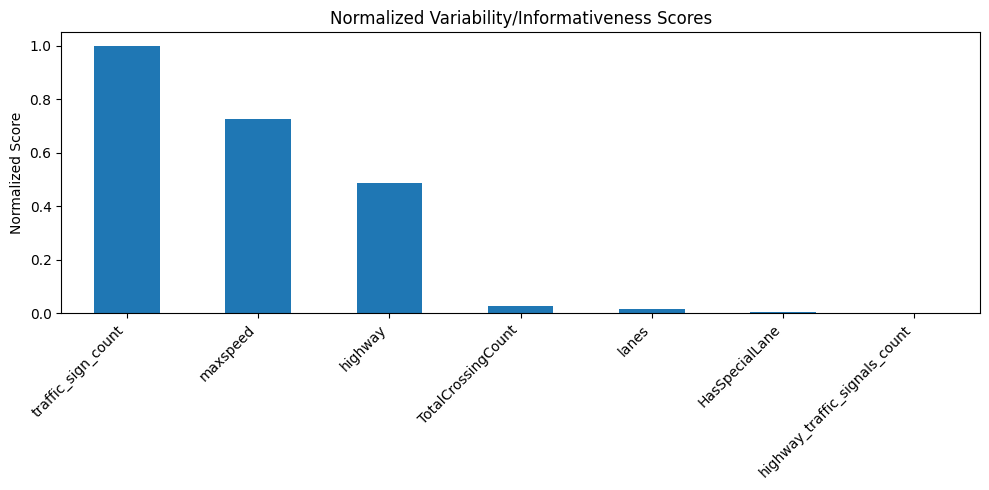

In [18]:
# 9. Qualitative Analysis & Selection ---
# Note: The following selection methods are for analytical purposes and do not alter df_cluster.
# Option A: Threshold
threshold = 0.2 # Example threshold
selected_features_thresh = scores_df[scores_df['NormalizedScore'] > threshold].index.tolist()
print(f"\nFeatures that should be selected using threshold > {threshold}:", selected_features_thresh)

# Option B: Top N
top_n = 8 # Example: Select top 8 features
selected_features_topn = scores_df.head(top_n).index.tolist()
print(f"\nFeatures that should be selected if picking Top {top_n}:", selected_features_topn)

# Option C: Manual Selection based on plot/domain knowledge
scores_df['NormalizedScore'].plot(kind='bar', figsize=(10, 5))
plt.title('Normalized Variability/Informativeness Scores')
plt.ylabel('Normalized Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Checking Redundancy...

Correlation Matrix (Selected Numerical):
                                  lanes  traffic_sign_count  \
lanes                          1.000000            0.102363   
traffic_sign_count             0.102363            1.000000   
highway_traffic_signals_count  0.184566            0.218039   
TotalCrossingCount             0.041663            0.256385   

                               highway_traffic_signals_count  \
lanes                                               0.184566   
traffic_sign_count                                  0.218039   
highway_traffic_signals_count                       1.000000   
TotalCrossingCount                                  0.367170   

                               TotalCrossingCount  
lanes                                    0.041663  
traffic_sign_count                       0.256385  
highway_traffic_signals_count            0.367170  
TotalCrossingCount                       1.000000  


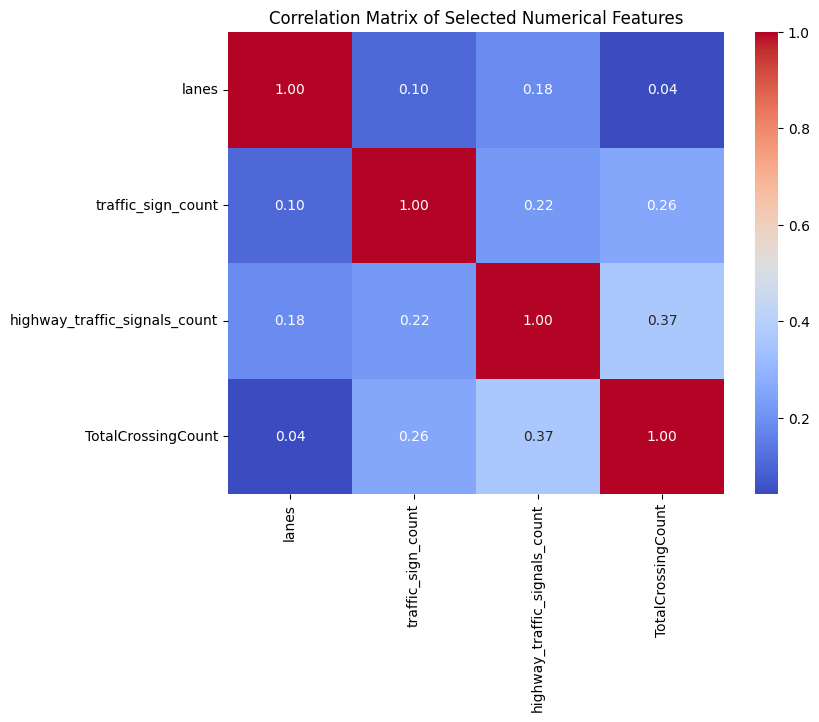


Cramer's V (Selected Categorical):
                maxspeed   highway  HasSpecialLane
maxspeed        1.000000  0.233573        0.090927
highway         0.233573  1.000000        0.193707
HasSpecialLane  0.090927  0.193707        1.000000


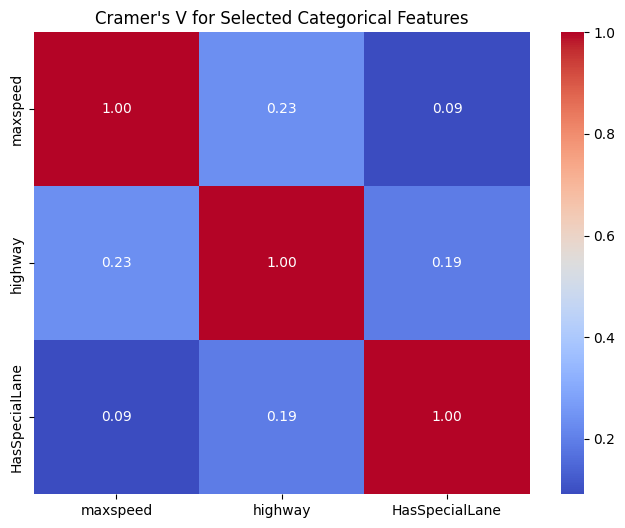

In [19]:
# 10. Check for Redundancy Among Features ---

print("\nChecking Redundancy...")
# Numerical Correlation
if len(numerical_cols) > 1:
    corr_matrix = df[numerical_cols].corr()
    print("\nCorrelation Matrix (Selected Numerical):")
    print(corr_matrix)
    # Visualize heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Selected Numerical Features')
    plt.show()
    # Decision: If high correlation (e.g., > |0.8|) is found between two variables,
    # consider removing one based on domain knowledge or lower variability score.

# Categorical Association (using Cramer's V)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
         # Handle cases with zero degrees of freedom (e.g., constant variable)
         # This shouldn't happen if we selected based on non-zero entropy/variance,
         # but good to have a fallback.
         return 0.0
    else:
         return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


if len(categorical_cols) > 1:
    print("\nCramer's V (Selected Categorical):")
    cramer_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramer_results.loc[col1, col2] = 1.0
            else:
                cramer_results.loc[col1, col2] = cramers_v(df[col1], df[col2])
    # Convert to numeric after filling
    cramer_results = cramer_results.astype(float)
    print(cramer_results)
    # Visualize
    plt.figure(figsize=(8, 6))
    sns.heatmap(cramer_results, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Cramer's V for Selected Categorical Features")
    plt.show()
    # Decision: If high Cramer's V (e.g., > 0.7) is found, consider removing one.

# DETERMINING OPTIMAL K, USING 2 METHODS

## Determining optimal k using the Elbow Method

Running Cluster 1:
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Running Cluster 2:
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 30152135.50076184
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 296135, ncost: 22331978.851758163
Run: 8, iteration: 2/100, moves: 96151, ncost: 22155025.619623277
Run: 8, iteration: 3/100, moves: 11601, ncost: 22151436.243625697
Run: 8, iteration: 4/100, moves: 0, ncost: 22151436.243625697
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 30152135.50076184
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 140427, ncost: 22269675.053947262
Run: 2, iteration:

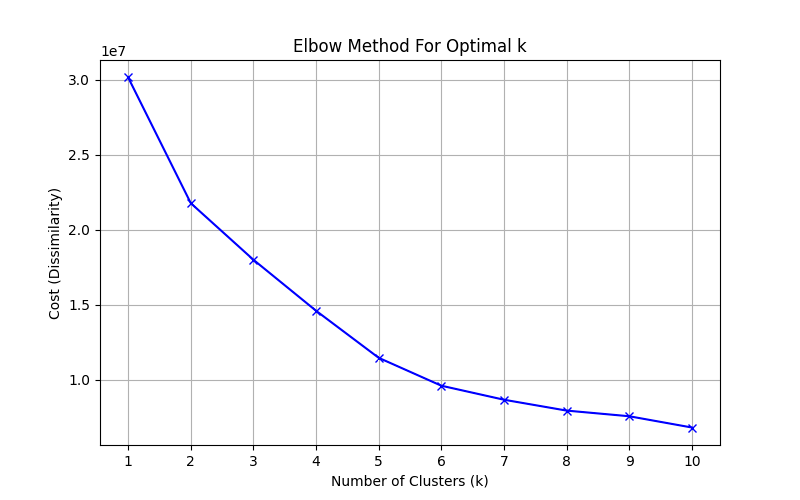

In [21]:
costs = []
K = range(1, 11)  # Test cluster numbers from 1 to 10 (adjust range as needed)

for num_clusters in list(K): #iterate through cluster numbers
    print(f"Running Cluster {num_clusters}:")
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', verbose=2, random_state=0, n_jobs=-1) #n_jobs=-1 uses all available cores
    kproto.fit_predict(X_cluster, categorical=categorical_indices)
    costs.append(kproto.cost_) #Append cost to costs list

plt.figure(figsize=(8, 5))
plt.plot(K, costs, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Dissimilarity)')
plt.grid(True)
plt.xticks(list(K))
plt.savefig(os.path.join(FIGURES_DIR, 'elbow_method.png'))
plt.show() #Plot elbow

## Determining Optimal k using the Silhouette Method

In [ ]:
print("Starting the Silhouette Method")
silhouette_avg = []
K = range(2, 11)  # Adjust range as needed

for num_clusters in list(K):
    print(f"Running Cluster {num_clusters}:")
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', verbose=2, random_state=0, n_jobs=-1)
    cluster_labels = kproto.fit_predict(X_cluster, categorical=categorical_indices)

    # --- One-hot encode categorical features before calculating Silhouette score ---
    df_silhouette = df_prep.copy()  # Create a copy for one-hot encoding
    df_silhouette = pd.get_dummies(df_silhouette, columns=categorical_cols)
    silhouette_avg = silhouette_score(df_silhouette.values, cluster_labels)  # Average score for all samples

    sample_silhouette_values = silhouette_samples(df_silhouette.values, cluster_labels) #Silhouette values for each sample

    # --- Create the Silhouette plot ---
    n_clusters = num_clusters  # Assign num_clusters to n_clusters so it is defined in this scope.
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)
    ax1.set_xlim([-0.1, 1])  #xlim and ylim values are fixed, adapt if needed
    ax1.set_ylim([0, len(df_silhouette) + (n_clusters + 1) * 10]) # adapt if needed
    y_lower = 10

    for i in range(n_clusters): #Iterate through cluster labels

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] #Silhouette scores for current cluster
        ith_cluster_silhouette_values.sort() #Sort silhouette scores

        size_cluster_i = ith_cluster_silhouette_values.shape[0] #number of samples in cluster i
        y_upper = y_lower + size_cluster_i


        color = plt.cm.nipy_spectral(float(i) / n_clusters)  # Customize colors if needed
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) #Label the silhouette plots with their cluster numbers at the middle


        y_lower = y_upper + 10  # 10 for the 0 samples


    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



    plt.suptitle(("Silhouette analysis for KPrototypes clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, f'silhouette_full_data_k_{n_clusters}.png'))
    plt.show()

## Determining Optimal k using the Silhouette Method on a Sample

Starting the Silhouette Method using Sampling

Running KPrototypes for k = 3 on full data...
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 617699, ncost: 18708076.583301146
Run: 1, iteration: 2/100, moves: 64210, ncost: 18646197.966556508
Run: 1, iteration: 3/100, moves: 4846, ncost: 18645388.428089086
Run: 1, iteration: 4/100, moves: 0, ncost: 18645388.428089086
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 273402, ncost: 18401229.236643966
Run: 5, iteration: 2/100, moves: 18909, ncost: 18393113.62719567
Run: 5, iteration: 3/100, moves: 1585, ncost: 18392978.632062726
Run: 5, iteration: 4/100, moves: 0, ncost: 18392978.632062726
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iterati

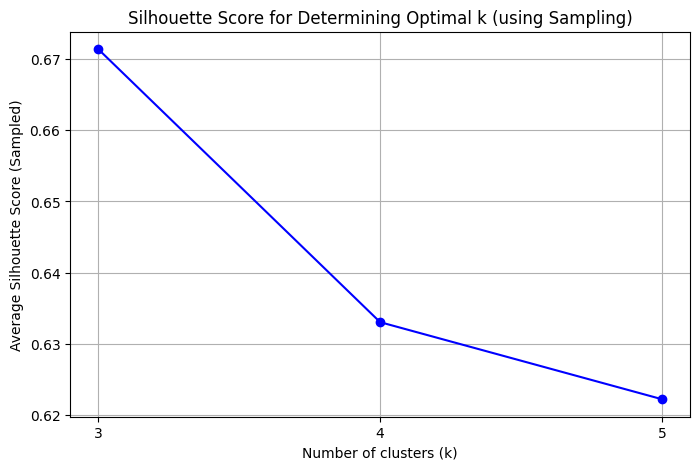

In [23]:
print("Starting the Silhouette Method using Sampling")
silhouette_scores_avg = [] # Store average scores for each k
K = range(3, 6)  # Adjust range as needed
SAMPLE_SIZE = 700000  # Or 5000, 20000 etc. Adjust based on your RAM. Needs to be large enough to be representative.
if SAMPLE_SIZE > len(df_prep):
    SAMPLE_SIZE = len(df_prep) # Don't sample more than available data

for num_clusters in K:
    print(f"\nRunning KPrototypes for k = {num_clusters} on full data...")
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', verbose=2, random_state=0, n_jobs=-1) # Use all cores

    # Fit on FULL data, predict on FULL data
    cluster_labels = kproto.fit_predict(X_cluster, categorical=categorical_indices)
    print(f"KPrototypes done for k = {num_clusters}.")

    # --- Perform Sampling for Silhouette ---
    print(f"Sampling {SAMPLE_SIZE} points for Silhouette calculation...")
    if len(df_cluster) > SAMPLE_SIZE:
        # Create random indices
        sample_indices = np.random.choice(df_cluster.index, SAMPLE_SIZE, replace=False)
        # Select sample data AND corresponding labels
        df_sample = df_prep.loc[sample_indices]
        labels_sample = cluster_labels[sample_indices]
    else:
        # If dataset is smaller than sample size, use all data
        df_sample = df_prep.copy()
        labels_sample = cluster_labels

    print("One-hot encoding the sample...")
    # One-hot encode ONLY the sample
    df_silhouette_sample = pd.get_dummies(df_sample, columns=categorical_cols)

    print("Calculating Silhouette score on the sample...")
    # Calculate Silhouette score using ONLY the sample data and labels
    silhouette_avg = silhouette_score(df_silhouette_sample.values, labels_sample)  # Average score for all samples
    silhouette_scores_avg.append(silhouette_avg)
    print(f"Average Silhouette Score for k = {num_clusters}: {silhouette_avg:.4f}")
    sample_silhouette_values = silhouette_samples(df_silhouette_sample.values, labels_sample) #Silhouette values for each sample
      
    # --- Create the Silhouette plot ---
    print("Start plotting...")
    n_clusters = num_clusters  # Assign num_clusters to n_clusters so it is defined in this scope.
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)
    ax1.set_xlim([-0.1, 1])  #xlim and ylim values are fixed, adapt if needed
    ax1.set_ylim([0, len(df_silhouette_sample) + (n_clusters + 1) * 10]) # adapt if needed
    y_lower = 10

    for i in range(n_clusters): #Iterate through cluster labels

        ith_cluster_silhouette_values = sample_silhouette_values[labels_sample == i] #Silhouette scores for current cluster
        ith_cluster_silhouette_values.sort() #Sort silhouette scores

        size_cluster_i = ith_cluster_silhouette_values.shape[0] #number of samples in cluster i
        y_upper = y_lower + size_cluster_i


        color = plt.cm.nipy_spectral(float(i) / n_clusters)  # Customize colors if needed
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) #Label the silhouette plots with their cluster numbers at the middle


        y_lower = y_upper + 10  # 10 for the 0 samples


    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



    plt.suptitle(("Silhouette analysis for KPrototypes clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, f'silhouette_sampled_k_{n_clusters}.png'))
    plt.close(fig) # Close the figure to free up memory

    # --- Optional: Clean up large objects ---
    del df_sample, labels_sample, df_silhouette_sample, kproto, cluster_labels
    gc.collect() # Force garbage collection (might help, might not)

# --- Plotting the results (handling potential NaNs) ---
valid_indices = ~np.isnan(silhouette_scores_avg) # Find where scores are not NaN
valid_K = np.array(list(K))[valid_indices]
valid_scores = np.array(silhouette_scores_avg)[valid_indices]

# --- Plotting the results (Average Silhouette Scores vs K) ---
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores_avg, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score (Sampled)')
plt.title('Silhouette Score for Determining Optimal k (using Sampling)')
plt.grid(True)
plt.xticks(list(K))
plt.savefig(os.path.join(FIGURES_DIR, 'silhouette_method_average_scores_sampled.png'))
plt.show()

# K-Prototypes clustering

In [24]:
# --- Choose optimal k based on the elbow plot ---
# Examine the Elbow and Silhouette performed before and select the k value at the "elbow" point
# (where the rate of decrease in cost starts to slow down significantly).
#Then, update below the value of n_clusters

n_clusters=4

# --- Perform K-Prototypes clustering with the optimal k ---
print(f"Running K-Prototypes with {n_clusters} clusters.")
kproto = KPrototypes(n_clusters=n_clusters, init='Cao', verbose=2, random_state=0, n_jobs=-1)
clusters = kproto.fit_predict(X_cluster, categorical=categorical_indices)

df['cluster'] = clusters
print("Clustering complete. Cluster labels added to the main DataFrame.")

# --- 3. Manually Reconstruct and Save Centroids ---

print("\nReconstructing and saving centroids...")
flawed_centroids_array = kproto.cluster_centroids_
numerical_part_str = flawed_centroids_array[:, :num_numerical]
categorical_part = flawed_centroids_array[:, num_numerical:]
numerical_centroids_final = numerical_part_str.astype('float64')
categorical_centroids_final = categorical_part

# Verification
print("\n--- Reconstructed Centroids (Verification) ---")
print(f"Final Numerical Centroids Shape: {numerical_centroids_final.shape}")
print(f"Final Categorical Centroids Shape: {categorical_centroids_final.shape}")

# Save the corrected centroids
numerical_centroids_path = os.path.join(RESULTS_DIR, "numerical_centroids.npy")
categorical_centroids_path = os.path.join(RESULTS_DIR, "categorical_centroids.npy")
np.save(numerical_centroids_path, numerical_centroids_final)
np.save(categorical_centroids_path, categorical_centroids_final)
print("Centroids saved successfully.")
print("-" * 50)


# --- 4. Analyze Cluster Characteristics (Using the Correct DataFrame) ---

print("\n--- Analyzing Cluster Characteristics ---")
print("Total edges in each cluster:")
print(df['cluster'].value_counts())

for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]
    print(f"\n--- Cluster {i} ---")

    if cluster_data.empty:
        print("This cluster is empty.")
        continue

    # Analyze based on the original, interpretable features
    for feature in final_feature_list:
        counts = cluster_data[feature].value_counts().head(10) # Show top 10 for brevity
        print(f"  Feature '{feature}' value counts:")
        print(counts.to_string())
        
print("\nCluster analysis complete.")
print("-" * 50)

Running K-Prototypes with 4 clusters.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 861441, ncost: 16434990.974070476
Run: 6, iteration: 2/100, moves: 145934, ncost: 16258457.413184779
Run: 6, iteration: 3/100, moves: 1482, ncost: 16258276.314786855
Run: 6, iteration: 4/100, moves: 32, ncost: 16258276.159768336
Run: 6, iteration: 5/100, moves: 0, ncost: 16258276.159768336
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 940575, ncost: 15394084.630259516
Run: 10, iteration: 2/100, moves: 15716, ncost: 15380039.884522023
Run: 10, iteration: 3/100, moves: 4490, ncost: 15378496.021667836
Run: 10, iteration: 4/100, moves: 304, ncost: 15378485.526415637
Run: 10, iteration: 5/100, moves: 0, ncost: 15378485.526415637
Init: initializing centroids
Init: initializing clusters
Starting iterati

# Saving final results

In [25]:
cluster_results_gpkg_path = os.path.join(RESULTS_DIR, "full_network_with_clusters.gpkg")
cluster_results_csv_path = os.path.join(RESULTS_DIR, "full_network_with_clusters.csv")

df_to_save = df.copy()

# Save to GeoPackage
try:
    print(f"Saving clustered network with geometry to: {cluster_results_gpkg_path}")
    df_to_save.to_file(cluster_results_gpkg_path, driver="GPKG")
except Exception as e:
    print(f"Error saving clustered GPKG: {e}")

# Save to CSV
try:
    print(f"Saving clustered attributes to: {cluster_results_csv_path}")
    df_to_save.to_csv(cluster_results_csv_path, sep=";", index=False)
except Exception as e:
    print(f"Error saving clustered CSV: {e}")

print("\nScript finished successfully.")

Saving clustered network with geometry to: /Anonymized/results/full_network_with_clusters.gpkg
Saving clustered attributes to: /Anonymized/results/full_network_with_clusters.csv

Script finished successfully.
